In [1]:
import torch
import odl
import numpy as np
import odl.contrib.torch as odl_torch
import matplotlib.pyplot as plt
import time
import sys
import os
from pathlib import Path
SRC = os.path.abspath("..")
if not SRC in sys.path:
    sys.path.append(SRC)
from geometries.fanbeam_geometry.fanbeam_geometry import FlatFanBeamGeometry

############## SETTINGS
beta_size=720
u_size=560
src_radius = 410.66
det_radius = 143.08
src_detector = src_radius + det_radius #-10 # 543.74 is wrong?
lims = [[-40., 40.], [-40., 40.]]
lims_reorder = [[lims[i][j] for i in range(2)] for j in range(2)]
lims_ravel = [lims[i][j] for i in range(2) for j in range(2)]
shape = [512, 512]
partition = (-56,56)
############################


DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

phantoms = torch.stack(torch.load("../../data/HTC2022/HTCTestPhantomsFull.pt"))[:5].to(DEVICE)
data = torch.stack(torch.load("../../data/HTC2022/HTCTestDataFull.pt"))[:5].to(DEVICE)


reco_space = odl.uniform_discr(min_pt=lims_reorder[0], max_pt=lims_reorder[1], shape=shape, dtype='float32')
angle_partition = odl.uniform_partition(0, 2 * np.pi, beta_size)
detector_partition = odl.uniform_partition(*partition, u_size)
geometry = odl.tomo.FanBeamGeometry(angle_partition, detector_partition, src_radius=src_radius, det_radius=det_radius) # custom setting?

g = FlatFanBeamGeometry(beta_size=beta_size, u_size=u_size, src_origin=src_radius, src_detector=src_detector,
                        detector_size=partition[1]-partition[0], xy_minmax_bounds=lims_ravel, reco_shape=shape)

# --- Create Filtered Back-projection (FBP) operator --- #


ray_trafo = odl.tomo.RayTransform(reco_space, geometry)
fbp = odl.tomo.fbp_op(ray_trafo, filter_type='Ram-Lak', frequency_scaling=0.8) # Hann

Ray = odl_torch.OperatorModule(ray_trafo)
bp = odl_torch.OperatorModule(ray_trafo.adjoint)
FBP = odl_torch.OperatorModule(fbp)


sinos = Ray(phantoms)
recon_odl = FBP(sinos)

sinos_our = g.Ray(phantoms)
recon_our = g.BP(g.inverse_fourier_transform(g.fourier_transform(sinos_our*g.jacobian_det)*g.ram_lak_filter()/2.))
recon_our_nojac = g.BP(g.inverse_fourier_transform(g.fourier_transform(sinos_our)*g.ram_lak_filter()/2.))

c:\Users\salom\anaconda3\envs\KEX\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\salom\anaconda3\envs\KEX\lib\site-packages\odl\tomo\backends\astra_cpu.py:318: RuntimeWarning: The 'astra_cpu' backend may be too slow for volumes of this size. Consider using 'astra_cuda' if your machine has an Nvidia GPU.
  warnings.warn(


Text(0.5, 1.0, 'Custom FBP, no jac')

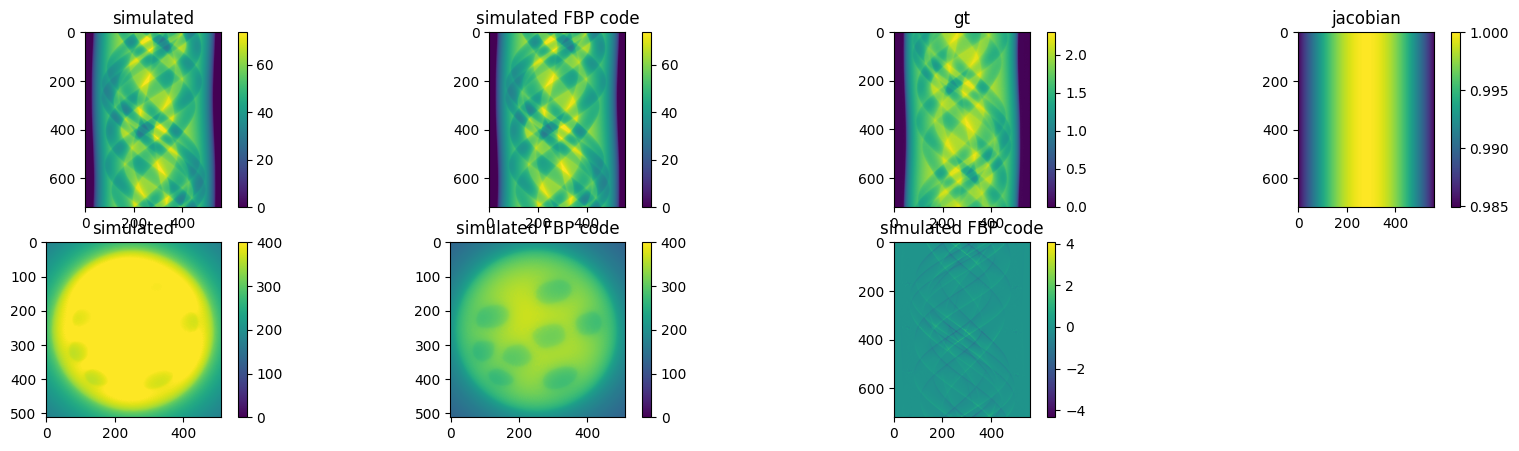

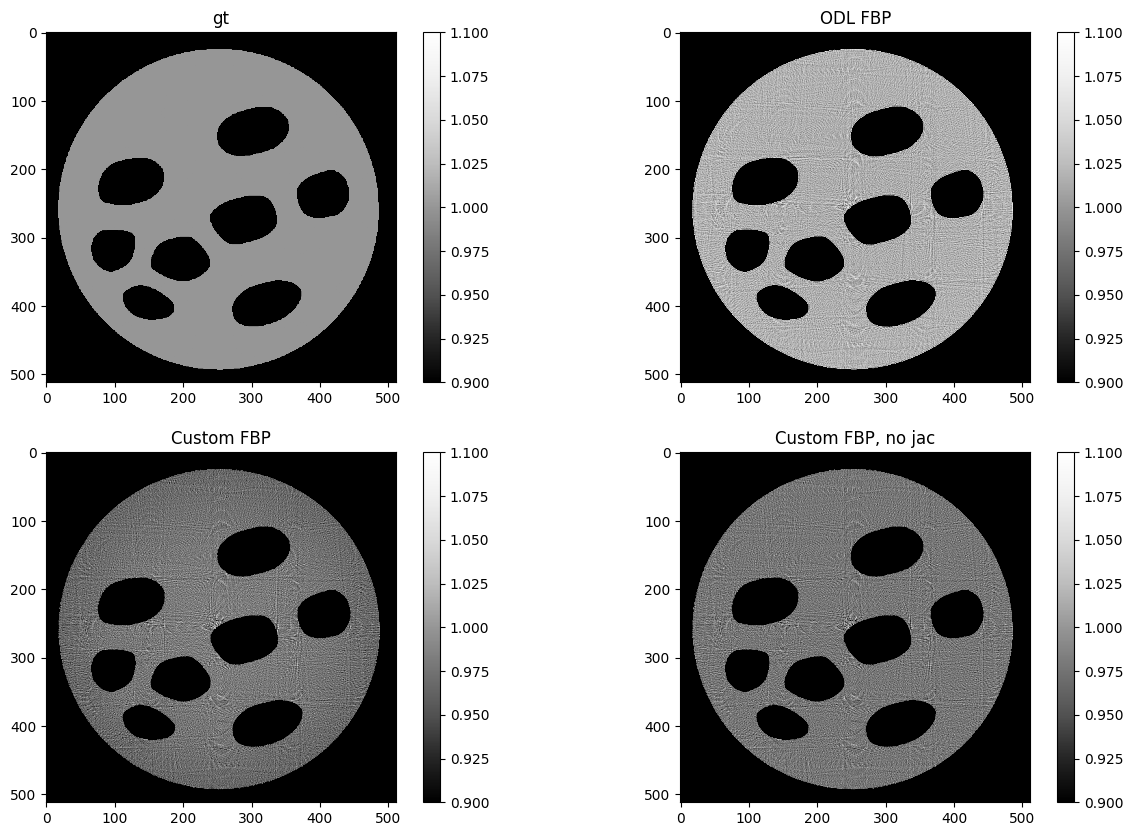

In [2]:
#print(sinos[None, :].shape)


look_at_ind = 2

kwargs = {"vmax": 1.1, "vmin": 0.9, "cmap": "Greys_r"}

plt.figure(figsize=(20,5))
plt.subplot(241)
plt.imshow(sinos[look_at_ind].cpu())
plt.title("simulated")
plt.colorbar()

plt.subplot(242)
plt.imshow(sinos_our[look_at_ind].cpu())
plt.title("simulated FBP code")
plt.colorbar()

plt.subplot(243)
plt.imshow(data[look_at_ind].cpu())
plt.title("gt")
plt.colorbar()

plt.subplot(244)
plt.imshow((torch.ones_like(sinos[look_at_ind]) * g.jacobian_det).cpu())
plt.title("jacobian")
plt.colorbar()

# Backprop
plt.subplot(245)
plt.imshow(bp(sinos)[look_at_ind].cpu(), vmin=0, vmax=400)
plt.title("simulated")
plt.colorbar()

plt.subplot(246)
plt.imshow(g.BP(sinos)[look_at_ind].cpu(), vmin=0, vmax=400)
plt.title("simulated FBP code")
plt.colorbar()

plt.subplot(247)
plt.imshow((sinos-sinos_our)[look_at_ind].cpu())
plt.title("simulated FBP code")
plt.colorbar()




plt.figure(figsize=(15, 10))
plt.subplot(221)
plt.imshow(phantoms[look_at_ind].cpu(), **kwargs)
plt.colorbar()
plt.title("gt")

plt.subplot(222)
plt.imshow(recon_odl[look_at_ind].cpu()*1100, **kwargs)
plt.colorbar()
plt.title("ODL FBP")

plt.subplot(223)
plt.imshow(recon_our[look_at_ind].cpu(), **kwargs)
plt.colorbar()
plt.title("Custom FBP")

plt.subplot(224)
plt.imshow(recon_our_nojac[look_at_ind].cpu(), **kwargs)
plt.colorbar()
plt.title("Custom FBP, no jac")

In [ ]:
phantoms = torch.load("../../data/kits_phantoms_256.pt")[:500, 0]
print(phantoms.shape)


reco_space = odl.uniform_discr(
    min_pt=[-1.0, -1.0], max_pt=[1.0, 1.0], shape=[256, 256],
    dtype='float32')
angle_partition = odl.uniform_partition(0, 2 * np.pi, 700)
detector_partition = odl.uniform_partition(-1.0, 1.0, 560)

geometry = odl.tomo.FanBeamGeometry(
    angle_partition, detector_partition, src_radius=6.0, det_radius=4.0)
# --- Create Filtered Back-projection (FBP) operator --- #

ray_trafo = odl.tomo.RayTransform(reco_space, geometry)
fbp = odl.tomo.fbp_op(ray_trafo, filter_type='Hann', frequency_scaling=0.8)

Ray = odl_torch.OperatorModule(ray_trafo)

# geometry = FlatFanBeamGeometry(720, 560, 410.66, 543.74, 112, [-40,40, -40, 40], [512, 512])
# geometry = FlatFanBeamGeometry(700, 560, 6.0, 10.0, 2.0, [-1.0,1.0, -1.0, 1.0], [256, 256])
# plt.imshow(phantoms[0].cpu())
# plt.show()
start = time.time()
sinos = Ray(phantoms)

plt.imshow(sinos[2].cpu())
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: '../../data/kits_phantoms_256.pt'

In [18]:
"""
Example using a filtered back-projection (FBP) in fan beam using `fbp_op`.

Note that the FBP is only approximate in this geometry, but still gives a
decent reconstruction that can be used as an initial guess in more complicated
methods.
"""
import astra
from astra import create_proj_geom
import numpy as np
import numpy as np
import odl


det_width = 120
det_count = 560
angles = np.linspace(0,2*np.pi, 721)
source_origin = 410.66
origin_det = 143.08
proj_geom = create_proj_geom('fanflat', det_width, det_count, angles, source_origin, origin_det)


# --- Set up geometry of the problem --- #


# Reconstruction space: discretized functions on the cube
# [-20, 20]^2 with 300 samples per dimension.
reco_space = odl.uniform_discr(min_pt=[-20, -20], max_pt=[20, 20], shape=[300, 300], dtype='float32')

# Make a circular cone beam geometry with flat detector
# Angles: uniformly spaced, n = 360, min = 0, max = 2 * pi
angle_partition = odl.uniform_partition(0, 2 * np.pi, 360)
# Detector: uniformly sampled, n = 512, min = -60, max = 60
detector_partition = odl.uniform_partition(-60, 60, 512)
# Geometry with large fan angle
geometry = odl.tomo.FanBeamGeometry(angle_partition, detector_partition, src_radius=40, det_radius=40)


# --- Create Filtered Back-projection (FBP) operator --- #
# Ray transform (= forward projection).
ray_trafo = odl.tomo.RayTransform(reco_space, geometry)

# Create FBP operator using utility function
# We select a Hann filter, and only use the lowest 80% of frequencies to avoid
# high frequency noise.
fbp = odl.tomo.fbp_op(ray_trafo, filter_type='Hann', frequency_scaling=0.8)


# --- Show some examples --- #
# Create a discrete Shepp-Logan phantom (modified version)
phantom = odl.phantom.shepp_logan(reco_space, modified=True)

# Create projection data by calling the ray transform on the phantom
proj_data = ray_trafo(phantom)

# Calculate filtered back-projection of data
fbp_reconstruction = fbp(proj_data)

# Shows a slice of the phantom, projections, and reconstruction
phantom.show(title='Phantom')
proj_data.show(title='Projection Data (Sinogram)')
fbp_reconstruction.show(title='Filtered Back-projection')
(phantom - fbp_reconstruction).show(title='Error', force_show=True)

0.001742908545680884

In [19]:
ray_trafo

RayTransform: uniform_discr([-40., -40.], [ 40.,  40.], (512, 512), dtype='float32') -> uniform_discr(
    [  0., -56.], [  6.28318531,  56.        ], (721, 560),
    dtype='float32'
)

In [22]:
fbp

OperatorComp(RayBackProjection: uniform_discr(
    [  0., -56.], [  6.28318531,  56.        ], (721, 560),
    dtype='float32'
) -> uniform_discr([-40., -40.], [ 40.,  40.], (512, 512), dtype='float32'), OperatorComp(OperatorRightVectorMult(OperatorComp(ResizingOperator: uniform_discr(
    [  -0., -112.], [   6.28318531,  111.8       ], (721, 1119),
    dtype='float32'
) -> uniform_discr(
    [  0., -56.], [  6.28318531,  56.        ], (721, 560),
    dtype='float32'
), FourierTransformInverse: DiscretizedSpace(
    uniform_partition([ -0.   , -15.722], [ 6.2832, -0.014 ], (721, 560), nodes_on_bdry=(False, (False, True))),
    cn((721, 560), dtype='complex64', weighting=0.0002447)
) -> uniform_discr(
    [  -0., -112.], [   6.28318531,  111.8       ], (721, 1119),
    dtype='float32'
)), DiscretizedSpace(
    uniform_partition([ -0.   , -15.722], [ 6.2832, -0.014 ], (721, 560), nodes_on_bdry=(False, (False, True))),
    cn((721, 560), dtype='complex64', weighting=0.0002447)
).element(
